# Support Vector Machines for Fall detection

In this Python notebook I create different SVM models for detecting falls using 3 sensors (accelerometer, gyroscope and magnetometer). This work uses FallAllD dataset, which was created by Saleh *et al*., (2021). The model will use all three axis of all three sensors. The dataset had to be modied for having a column for fall, in which 1 represents a fall, otherwise is an ADL. For comparison, another dataset has been created, which uses a second output column. This column, ADL, will have the opposite value of Fall. 

A third and fourth dataset was created in which basic statistical features are being used. Those features are: Mean, Standard Deviation and Range. These features were extracted for each of the axis of each sensor. A fifth and sixth dataset was created using the same features, altough just considering accelerometer data, just like Saleh *et al*., (2021) did in their work.

### Importing libraries

This libraries will help throughout the code

In [27]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import requests
import time
import pickle

### Notification System

This funciton will be used to send a Telegram message when training is done.

In [4]:
f = open("Notification system/Telegram Token.txt")
token = f.read()

def broadcast_message(chat, message):
    for chat_to_send in chat:
        URL = 'https://api.telegram.org/bot{}/sendMessage?chat_id={}&text={}'.format(token, chat_to_send, message)
        resp = requests.get(URL)
        print(resp.text)

### Reading frist dataframe

This is the dataframe containing one output column with raw data from all 3 sensors.

In [5]:
df = pd.read_pickle('Dataframes/Dataframe3.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SubjectID   1798 non-null   int8   
 1   Device      1798 non-null   object 
 2   ActivityID  1798 non-null   int16  
 3   TrialNo     1798 non-null   int8   
 4   Acc         1798 non-null   object 
 5   Gyr         1798 non-null   object 
 6   Mag         1798 non-null   object 
 7   Mean Acc X  1798 non-null   float64
 8   Mean Acc Y  1798 non-null   float64
 9   Mean Acc Z  1798 non-null   float64
 10  Std Acc X   1798 non-null   float64
 11  Std Acc Y   1798 non-null   float64
 12  Std Acc Z   1798 non-null   float64
 13  Rng Acc X   1798 non-null   float64
 14  Rng Acc Y   1798 non-null   float64
 15  Rng Acc Z   1798 non-null   float64
 16  Mean Gyr X  1798 non-null   float64
 17  Mean Gyr Y  1798 non-null   float64
 18  Mean Gyr Z  1798 non-null   float64
 19  Std Gyr X   1798 non-null  

In [6]:
X = df.iloc[:, 7:34]       # Defining X as Acce, Gyro and Mag data
X.info()                   # Printing X's info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mean Acc X  1798 non-null   float64
 1   Mean Acc Y  1798 non-null   float64
 2   Mean Acc Z  1798 non-null   float64
 3   Std Acc X   1798 non-null   float64
 4   Std Acc Y   1798 non-null   float64
 5   Std Acc Z   1798 non-null   float64
 6   Rng Acc X   1798 non-null   float64
 7   Rng Acc Y   1798 non-null   float64
 8   Rng Acc Z   1798 non-null   float64
 9   Mean Gyr X  1798 non-null   float64
 10  Mean Gyr Y  1798 non-null   float64
 11  Mean Gyr Z  1798 non-null   float64
 12  Std Gyr X   1798 non-null   float64
 13  Std Gyr Y   1798 non-null   float64
 14  Std Gyr Z   1798 non-null   float64
 15  Rng Gyr X   1798 non-null   float64
 16  Rng Gyr Y   1798 non-null   float64
 17  Rng Gyr Z   1798 non-null   float64
 18  Mean Mag X  1798 non-null   float64
 19  Mean Mag Y  1798 non-null  

In [7]:
y = df['Fall']          # Defining y as Fall column, this means setting y to our output.
y.tail()                # y is a Series object

1793    1
1794    1
1795    1
1796    1
1797    1
Name: Fall, dtype: int64

### Creating first SVM model

Choosing the best SVM kernel. The kernel can be Linear, Polynomial, Radial Basis Function and Sigmoid, so we will create, train and test every one of them to get the best model of a SVM classifier.

In [29]:
clf_lin_1 = SVC(kernel='linear', C=1)          # Parameter tuning is needed to get better results

#### Using tain test split

This function will help us to create a separate pandas DataFrame for testing the end result. So we are separating 10% of the data into a test set. With this we will be using the other 90% for training and validating our models.

In [13]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=17, stratify=y)
X.shape, X_test.shape

((1456, 27), (162, 27))

#### Using StratifiedKFold

Since we are using a K-Fold Cross Validation approach, we have to use KFold to create our folds for training and testing. In this case we will be using k = 10, where 9 sets will be used for training and 1 for validating. So this way every set gets a chance to be validated. 

By using StratifiedKFold we make sure that the output class is evenly distribuited through each fold. So this means that they are smaller chances of having only Falls in on set.

In [30]:
scores_lin_1 = []

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=17)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X, y):                      # Splitting dataset into 10 fold 
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    clf_lin_1.fit(X_train, y_train)
    scores_lin_1.append(clf_lin_1.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', sum(scores_lin_1) / len(scores_lin_1))         # 0.9486 accuracy   Randomstate=17 0.9498 accuracy
#print('Poly accuracy score: ', sum(scores_poly) / len(scores_poly))        # 0.8138 accuracy
#print('RBF accuracy score: ', sum(scores_rbf) / len(scores_rbf))           # 0.8757 accuracy
#print('Sig accuracy score: ', sum(scores_sig) / len(scores_sig))           # 0.6353 accuracy

{"ok":true,"result":{"message_id":88,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634144741,"text":"Training is done!"}}
Linear accuracy score:  0.9498724610297591


In [31]:
y_predicted = clf_lin_1.predict(X_test)       # 0.95      randomstate=17 0.9567 accuracy
print('Accuracy: ', accuracy_score(y_test, y_predicted))

Accuracy:  0.9567901234567902


In [53]:
for i in range(len(y_predicted)):
    
    if y_predicted[i] == 1:
        broadcast_message(['1766671538'], 'Fall detected!')

    else:
        broadcast_message(['1766671538'], 'Not a Fall!')
    
    time.sleep(30)

print('Accuracy: ', accuracy_score(y_test, y_predicted)) 

{"ok":true,"result":{"message_id":78,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634133587,"text":"Not a Fall!"}}
{"ok":true,"result":{"message_id":79,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634133618,"text":"Fall detected!"}}
{"ok":true,"result":{"message_id":80,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634133649,"text":"Not a Fall!"}}
{"ok":true,"result":{"message_id":81,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"ch

#### Using cross_val_score

By using this function, we will have similar results as the ones printed above. The cell above just shows what's going on inside the function cross_val_score, so from now on I will be using only cross_val_score.

In [48]:
print('Linear accuracy score: ', cross_val_score(clf_lin, X, y, cv=10).mean())      # 0.9478 accuracy       std = 0.9493
#print('Poly accuracy score: ', cross_val_score(clf_poly, X, y, cv=10).mean())       # 0.8186 accuracy
#print('RBF accuracy score: ', cross_val_score(clf_rbf, X, y, cv=10).mean())         # 0.8763 accuracy
#print('Sig accuracy score: ', cross_val_score(clf_sig, X, y, cv=10).mean())         # 0.6318 accuracy

broadcast_message(['1766671538'], 'Training is done!')

Linear accuracy score:  0.9427480916030534
{"ok":true,"result":{"message_id":77,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634133081,"text":"Training is done!"}}


#### Using GridSearchCV

By using the function GridSearchCV we can train an validate different SVM models with different **kernels**, **C** and **gamma** values for obtaining the best model with the best accuracy.

As shown above, the worst kernel to use for this application is Sigmoid kernel, so for this first approach we will be tuning the linear, poly and rbf models.

In [16]:
params = {'C': (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000)}

In [17]:
clf_grid = GridSearchCV(SVC(), params, cv=10, n_jobs=-1, verbose=1, scoring='accuracy')
clf_grid.fit(X,y)
print(clf_grid.best_params_)
df_grid_results = pd.DataFrame(clf_grid.cv_results_)
print(df_grid_results)
broadcast_message(['1766671538'], 'GridSearchCV is done!')

Fitting 10 folds for each of 13 candidates, totalling 130 fits
{'C': 1000}
    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.099133      0.006573         0.028225        0.001997   0.001   
1        0.093451      0.005105         0.027425        0.004241   0.005   
2        0.135038      0.024712         0.033711        0.005814    0.01   
3        0.099633      0.008351         0.026330        0.003709    0.05   
4        0.123569      0.020548         0.036204        0.010751     0.1   
5        0.234971      0.080584         0.067818        0.042888     0.5   
6        0.124178      0.017796         0.029559        0.007611       1   
7        0.109806      0.012784         0.020745        0.002815       5   
8        0.105319      0.011726         0.027576        0.007906      10   
9        0.158723      0.031187         0.024145        0.008660      50   
10       0.156629      0.033567         0.020507        0.003821     100   
11       0.28

In [19]:
df_grid_results[['param_C', 'mean_test_score', 'rank_test_score']]

,param_C,mean_test_score,rank_test_score
0,0.001,0.741077,12
1,0.005,0.741077,12
2,0.01,0.741082,11
3,0.05,0.822796,10
4,0.1,0.832390,9
5,0.5,0.862617,8
6,1,0.885985,7
7,5,0.903165,5
8,10,0.903155,6
9,50,0.909343,4


In [25]:
clf_lin_1000 = SVC(kernel='linear', C=1000)

scores_lin_1000 = []

k_fold = StratifiedKFold(n_splits=10,shuffle=True, random_state=17)      # Creating a Stratifiedd K fold object
# This loop can be done with one line of code using cross_val_score
for train_index, val_index in k_fold.split(X, y):                      # Splitting dataset into 10 fold 
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index] , y.iloc[val_index]

    clf_lin_1000.fit(X_train, y_train)
    scores_lin_1000.append(clf_lin_1000.score(X_val, y_val))

broadcast_message(['1766671538'], 'Training is done!')
print('Linear accuracy score: ', sum(scores_lin_1000) / len(scores_lin_1000)) 

{"ok":true,"result":{"message_id":87,"from":{"id":1917311024,"is_bot":true,"first_name":"FallAlert","username":"FallAlertPythonBot"},"chat":{"id":1766671538,"first_name":"Teddy","last_name":"Ordo\u00f1ez","username":"teddsords","type":"private"},"date":1634140637,"text":"Training is done!"}}
Linear accuracy score:  0.950543221539915


In [26]:
y_predicted_1000 = clf_lin_1000.predict(X_test)       # 0.95      randomstate=17 0.9567 accuracy
print('Accuracy: ', accuracy_score(y_test, y_predicted_1000))

Accuracy:  0.9382716049382716


#### Saving model to disk

Saving the model to disk so it can be loaded afterwards.

In [28]:
filename = 'SVM_linear_1000.sav'
pickle.dump(clf_lin_1000, open(filename, 'wb'))

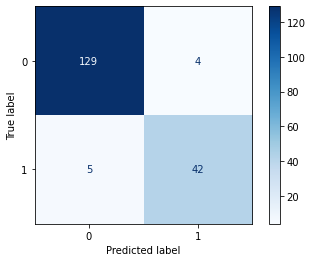

In [40]:
con_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap='Blues')
plt.show()